$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\vec}[1]{\textbf{#1}}
\newcommand{\vecg}[1]{\boldsymbol{#1}}
\newcommand{\h}{h_{\vecg{\vecg\Theta}}}
\newcommand{\inner}[2]{\langle{#1},{#2}\rangle}
\newcommand{\pd}[1]{\frac{\partial}{\partial{#1}}}
$$

Last time we implemented a basic linear regression model on a dataset with 2 features and 3 outputs. However, there are a few points, which when addressed, can make our model faster and even simpler to use.

# 1. $\Theta$ and $\theta_0$

We defined our hypothesis function in terms of the coefficients $\Theta$ and the biases $\theta_0$. However, we can instead redefine our features and express $h_{\Theta}$ in terms of only $\Theta$. We can define a new feature $x_0$ of our dataset, which is always equal to 1 and move our biases inside $\Theta$. Thus we have:

$$
\begin{align}
\vecg\Theta\prime &\in \R^{K\times (M+1)} \\
\vecg\Theta x + \vecg\theta_0 &=
\begin{pmatrix}
\vecg\theta_{0_0} + \sum^M_{m=1}{\vecg\Theta_{0m} x_m } \\
... \\
\vecg\theta_{0_k} + \sum^M_{m=1}{\vecg\Theta_{km} x_m }
\end{pmatrix} \\
&=
\begin{pmatrix}
\vecg\theta_{0_0} x_0 + \sum^M_{m=1}{\vecg\Theta_{0m} x_m } \\
... \\
\vecg\theta_{0_k} x_0 + \sum^M_{m=1}{\vecg\Theta_{km} x_m }
\end{pmatrix} \\
&=
\begin{pmatrix}
\sum^M_{m=0}{\vecg\Theta\prime_{0m} x_m } \\
... \\
\sum^M_{m=0}{\vecg\Theta\prime_{km} x_m }
\end{pmatrix} \\
&= \vecg\Theta\prime x
\end{align}
$$

# 2. Simplifying $\nabla J$

Previously, we defined $\nabla J$ as:

$$
(\nabla J)_j = \frac{1}{n}\sum_i^n{[\h(\vec x^i) - \vec y^i]\vec x^i_j}
$$

Substituting $\vec e = \h(\vec X)- \vec Y$, we get:

$$
(\nabla J)_j = \frac{1}{n}\sum_i^n{\vec e_i\vec x^i_j}
$$

We can now see that this is a matrix product, which allows us to rewrite the whole gradient as a vector expression:

$$
\nabla J = \frac{1}{n}\vec e \vec X^T = \frac{1}{n}(\h(\vec X) - \vec Y)\vec X^T
$$

# 2. Normalization

When the dataset's features have very different ranges, gradient descent can be slow to converge. In order to address this, we can **normalize** our features to the same ranges.

There are a few different techniques for normalization. Some of them are:

### Feature scaling

Feature scaling clamps all the values in the range $[0; 1]$.

$$
x\prime = \frac{x - x_{min}}{x_{max} - x_{min}}
$$

### Student's $t$-statistic ($z$-score)
This method does not clamp the values to a specific range, however it ensures that

- The mean is at 0
- The standard deviation is equal to 1
$$
x\prime = \frac{x - \overline{x}}{s}
$$

Consider the following two cases, where a gradient descent operates on the same dataset normalized and non-normalized.

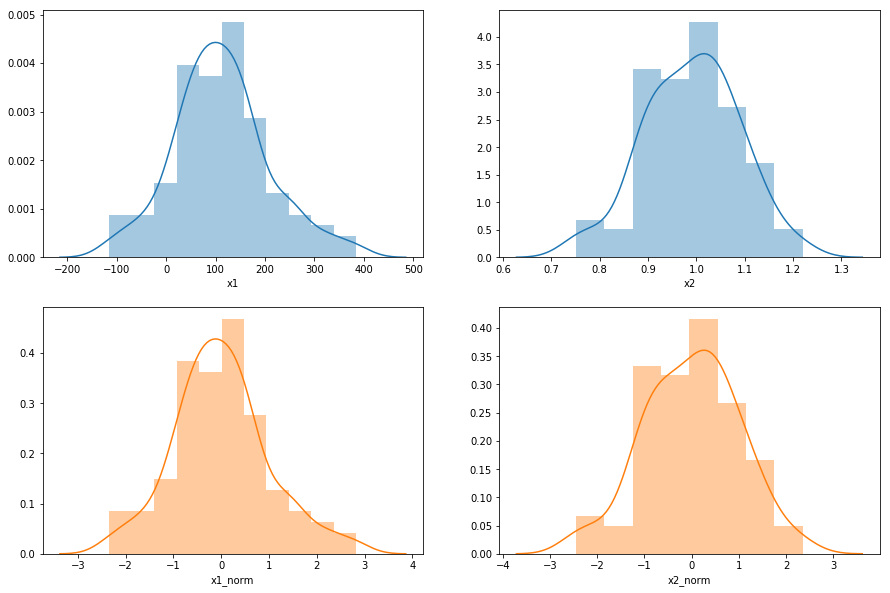

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML

N = 100
THETA = np.array([25, 0.1, 2]) # Include Theta_0 at first position

data = pd.DataFrame([])
data['x0'] = np.ones(N)
data['x1'] = np.random.normal(100, 100, N)
data['x2'] = np.random.normal(1, .1, N)
for c in data.columns[1:]:
    data[f"{c}_norm"] = (data[c] - data[c].mean()) / data[c].std()

X = data[['x0', 'x1', 'x2']].T.to_numpy()
X_norm = data[['x0', 'x1_norm', 'x2_norm']].T.to_numpy()
    
data['y'] = THETA @ data[data.columns[:3]].T
Y = data['y'].to_numpy()

fig,ax = plt.subplots(2, 2, figsize=(15, 10))
for i,c in enumerate(data.columns[1:3]):
    sns.distplot(data[c], ax=ax[0, i])
    sns.distplot(data[f"{c}_norm"], ax=ax[1, i], color=sns.color_palette()[1])


In [14]:
def gradientDescent(X, Y, alpha, iterations):
    theta = np.zeros(X.shape[0])
    def J(theta):
        return (-.5/N) * np.sum((theta @ X - Y) ** 2)
    def dJ(theta):
        p = theta @ X - Y
        return (-1/N) * (p @ X.T)
    js = [J(theta)]
    for i in range(iterations):
        theta = theta + alpha * dJ(theta)
        js.append(J(theta))
    return theta,np.array(js)

Final thetas:
Non-normalized: [10.6242159   0.13080124 10.51055599]
Real          : [25.   0.1  2. ]

Normalized (a): [24.93383566  0.10050378  2.01007563]
Real          : [25.   0.1  2. ]


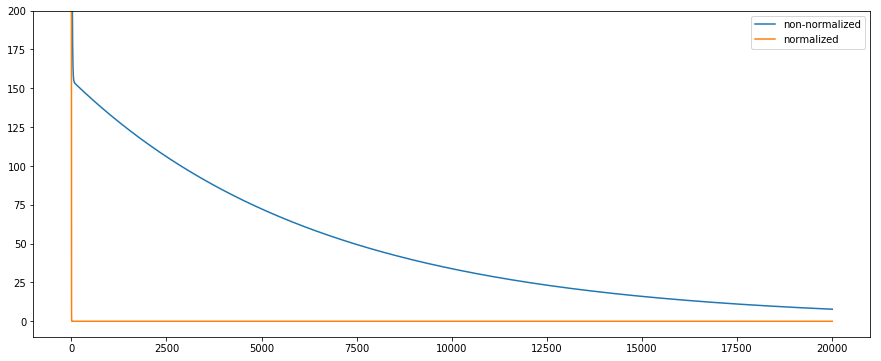

In [15]:
theta1,gd = gradientDescent(X, Y, 0.00009, 20000)
theta2,gd1 = gradientDescent(X_norm, Y, .4, 20000)

fig,ax = plt.subplots(1, 1, figsize=(15, 6))
sns.lineplot(range(len(gd)), -gd, label='non-normalized')
sns.lineplot(range(len(gd1)), -gd1, label='normalized')
ax.set_ylim(-10, 200)

print("Final thetas:")
print("Non-normalized:", theta1)
print("Real          :", THETA)
print()
theta2[0] = theta2[0] - np.inner(theta2[1:], np.mean(X[1:], axis=1) / np.std(X[1:], axis=1))
theta2[1:] = theta2[1:] / np.std(X[1:], axis=1)
print("Normalized (a):", theta2)
print("Real          :", THETA)

We see that the non-normalized data's model is stuck. This is because $\theta_1$ gets normalized first, and then the gradient's magnitude becomes very small, which results in very small steps being taken.

On the other hand, the normalized data's model converges almost immediately!

## Footnotes

We can extract the raw coefficients from the standardized ones with the following formula:

$$
\begin{align}
\theta_0 &= \hat{\theta}_0 - \sum^M_i{ \frac{\theta_m\overline{x_m}}{S_m}  } \\
\theta_m &= \frac{\hat{\theta}_m}{S_m}
\end{align}
$$